# Multiple Linear Regression (MLR) Analysis

This notebook applies **Multiple Linear Regression (MLR)** to analyze the relationship between institutional characteristics and median earnings 10 years after enrollment. Unlike the Random Forest model, MLR provides interpretable coefficients, allowing us to quantify the influence of each feature on earnings in a linear fashion.

### Objective

The goal of this analysis is to:
1. Identify and quantify key factors that influence median earnings.
2. Interpret the direction and magnitude of each feature’s effect on the target variable.
3. Use MLR as a baseline for comparison with more complex models, such as the Random Forest, to assess trade-offs between interpretability and predictive accuracy.

### Approach

This analysis includes:
- Data preparation, including any transformations or scaling needed to optimize MLR performance.
- Model training and evaluation, focusing on interpreting the regression coefficients.
- Discussion of the implications of significant features, providing insights for institutions and policymakers.

This MLR model is a critical part of the overall project, as it offers an interpretable baseline model against which the performance of more complex models can be assessed.

---


## Data Preparation

To ensure consistency in our analysis, we replicate the data cleaning steps directly within this notebook. This includes handling missing values, creating new features, and performing any transformations necessary for optimal model performance.

The specific steps in this data preparation process are:
1. **Handling Missing Values**: Replacing or dropping missing values to ensure a complete dataset.
2. **Feature Engineering**: Creating new features, such as combining related variables or creating binary indicators, to enhance the model’s predictive power.
3. **Data Transformation**: Scaling or encoding variables as needed to align with the requirements of Multiple Linear Regression.

By replicating the data cleaning process, we maintain independence between this notebook and other models, ensuring reproducibility and a consistent methodology.

In [1]:
# Imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import joblib

In [2]:
# Importing dataset
df = pd.read_csv('../data/MERGED2014_15_PP.csv')

# Variables to keep 
variables = [
    'CONTROL', 'UGDS','AVGFACSAL', 'PCTPELL', 'COSTT4_A', 'COSTT4_P', 'MD_FAMINC',
    'MD_EARN_WNE_P10', 'INEXPFTE', 'C150_4', 'C150_L4', 'PCTFLOAN', 'DEBT_MDN', 
    'PCIP14', 'PCIP11', 'PCIP15', 'PCIP52', 'STUFACR'
]

# Subset the dataframe
df = df[variables]

df.info()

C:\Users\ajten\AppData\Local\Temp\ipykernel_22400\1785546488.py:2: DtypeWarning: Columns (1537,1540,1542,1575,1589,1606,1610,1614,1615,1729,1909,1910,1911,1912,1913) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/MERGED2014_15_PP.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7766 entries, 0 to 7765
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CONTROL          7766 non-null   int64  
 1   UGDS             7037 non-null   float64
 2   AVGFACSAL        4579 non-null   float64
 3   PCTPELL          7007 non-null   float64
 4   COSTT4_A         4037 non-null   float64
 5   COSTT4_P         2582 non-null   float64
 6   MD_FAMINC        7546 non-null   object 
 7   MD_EARN_WNE_P10  6951 non-null   object 
 8   INEXPFTE         7324 non-null   float64
 9   C150_4           2497 non-null   float64
 10  C150_L4          3946 non-null   float64
 11  PCTFLOAN         7007 non-null   float64
 12  DEBT_MDN         7709 non-null   object 
 13  PCIP14           7035 non-null   float64
 14  PCIP11           7035 non-null   float64
 15  PCIP15           7035 non-null   float64
 16  PCIP52           7035 non-null   float64
 17  STUFACR       

In [3]:
df.isnull().sum()

CONTROL               0
UGDS                729
AVGFACSAL          3187
PCTPELL             759
COSTT4_A           3729
COSTT4_P           5184
MD_FAMINC           220
MD_EARN_WNE_P10     815
INEXPFTE            442
C150_4             5269
C150_L4            3820
PCTFLOAN            759
DEBT_MDN             57
PCIP14              731
PCIP11              731
PCIP15              731
PCIP52              731
STUFACR             736
dtype: int64

In [4]:
for col in df.columns:
    if 'PS' in df[col].values:
        print(f"Column '{col}' contains 'PS'")

Column 'MD_FAMINC' contains 'PS'
Column 'MD_EARN_WNE_P10' contains 'PS'
Column 'DEBT_MDN' contains 'PS'


In [5]:
# List of columns that might contain 'PrivacySuppressed'
columns_to_clean = ['MD_EARN_WNE_P10', 'MD_FAMINC', 'DEBT_MDN']

# Replace 'PrivacySuppressed (PS)' with NaN
df[columns_to_clean] = df[columns_to_clean].replace('PS', np.nan)

# Convert the columns to numeric
for col in columns_to_clean:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where any NaN values exist in the specified columns to clean
df_clean = df.dropna(subset=columns_to_clean).copy()

In [6]:
df_clean.isnull().sum()

CONTROL               0
UGDS                414
AVGFACSAL          1777
PCTPELL             422
COSTT4_A           2053
COSTT4_P           4208
MD_FAMINC             0
MD_EARN_WNE_P10       0
INEXPFTE            377
C150_4             3367
C150_L4            3041
PCTFLOAN            422
DEBT_MDN              0
PCIP14              413
PCIP11              413
PCIP15              413
PCIP52              413
STUFACR             416
dtype: int64

In [7]:
# Create a general completion rate variable that combines C150_4 and C150_L4
df_clean['completion_rate'] = df_clean['C150_4'].combine_first(df_clean['C150_L4'])

# Create a general completion rate variable that combines C150_4 and C150_L4
df_clean['avg_attendance'] = df_clean['COSTT4_A'].combine_first(df_clean['COSTT4_P'])

# Handle missing values in critical variables and make a copy
critical_vars = ['UGDS','AVGFACSAL','PCTPELL','INEXPFTE', 'completion_rate', 'avg_attendance', 'DEBT_MDN']
df_clean = df_clean.dropna(subset=critical_vars).copy()

# Create binary variable for institution type
# 0 = Public, 1 = Private (combining nonprofit and for-profit)
df_clean['public_private'] = df_clean['CONTROL'].apply(lambda x: 0 if x == 1 else 1)

# Dropping redundant variables
df3 = df_clean.drop(['CONTROL','C150_4', 'C150_L4', 'COSTT4_A', 'COSTT4_P'], axis=1)

df3.isnull().sum()

UGDS               0
AVGFACSAL          0
PCTPELL            0
MD_FAMINC          0
MD_EARN_WNE_P10    0
INEXPFTE           0
PCTFLOAN           0
DEBT_MDN           0
PCIP14             0
PCIP11             0
PCIP15             0
PCIP52             0
STUFACR            0
completion_rate    0
avg_attendance     0
public_private     0
dtype: int64

In [8]:
# Final dataset
print("Cleaned Dataset Shape:", df3.shape)
df3.info()

Cleaned Dataset Shape: (3589, 16)
<class 'pandas.core.frame.DataFrame'>
Index: 3589 entries, 0 to 7333
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   UGDS             3589 non-null   float64
 1   AVGFACSAL        3589 non-null   float64
 2   PCTPELL          3589 non-null   float64
 3   MD_FAMINC        3589 non-null   float64
 4   MD_EARN_WNE_P10  3589 non-null   float64
 5   INEXPFTE         3589 non-null   float64
 6   PCTFLOAN         3589 non-null   float64
 7   DEBT_MDN         3589 non-null   float64
 8   PCIP14           3589 non-null   float64
 9   PCIP11           3589 non-null   float64
 10  PCIP15           3589 non-null   float64
 11  PCIP52           3589 non-null   float64
 12  STUFACR          3589 non-null   float64
 13  completion_rate  3589 non-null   float64
 14  avg_attendance   3589 non-null   float64
 15  public_private   3589 non-null   int64  
dtypes: float64(15), int64(1)
memory

## Exploratory Data Analysis (EDA)

For this analysis, we performed a streamlined EDA focusing on descriptive statistics and correlation analysis to identify potential relationships between institutional characteristics and median earnings 10 years after enrollment.

### Descriptive Statistics

We began with descriptive statistics to understand the distribution, central tendency, and variability of each variable. This provides an overview of the data, allowing us to identify any features with high variance or unusual distributions that may influence the model’s performance.

### Correlation Matrix

The correlation matrix heatmap displays the pairwise correlations between all variables in the dataset. This analysis helps identify features with strong linear relationships with the target variable (`MD_EARN_WNE_P10`) and among themselves, providing insights into which variables might be more influential in predicting median earnings.

#### Key Observations:
- **Strong Positive Correlations**: `MD_FAMINC` (Family Income) and `AVGFACSAL` (Average Faculty Salary) have high positive correlations with median earnings, suggesting these socioeconomic and institutional factors are closely tied to graduate outcomes.
- **Strong Negative Correlation**: `PCTPELL` (Percentage of Pell Grant Recipients) shows a notable negative correlation with median earnings, indicating that institutions with higher proportions of Pell Grant recipients generally have lower post-graduation earnings among their graduates.
- **Moderate Correlations**: Features like `avg_attendance` (Average Cost of Attendance), `DEBT_MDN` (Median Debt), and `STEM_Index` show moderate positive correlations with median earnings, which might indicate their relevance to the model.

This initial analysis highlights the features that could have the most significant impact on median earnings, setting the stage for the subsequent regression analysis.


In [9]:
# Descriptive statistics
print("Descriptive Statistics:")
print(df3[['public_private', 'UGDS','AVGFACSAL', 'PCTPELL', 'avg_attendance', 'MD_FAMINC',
    'MD_EARN_WNE_P10', 'INEXPFTE', 'completion_rate', 'PCTFLOAN', 'DEBT_MDN', 
    'PCIP14', 'PCIP11', 'PCIP15', 'PCIP52', 'STUFACR']].describe())

Descriptive Statistics:
       public_private           UGDS     AVGFACSAL      PCTPELL  \
count     3589.000000    3589.000000   3589.000000  3589.000000   
mean         0.599889    4206.743661   6323.631931     0.479273   
std          0.489989    7000.771397   2197.685680     0.203945   
min          0.000000      18.000000    748.000000     0.064000   
25%          0.000000     578.000000   4866.000000     0.324400   
50%          1.000000    1654.000000   6092.000000     0.446300   
75%          1.000000    4694.000000   7517.000000     0.632100   
max          1.000000  151558.000000  20650.000000     1.000000   

       avg_attendance      MD_FAMINC  MD_EARN_WNE_P10       INEXPFTE  \
count     3589.000000    3589.000000      3589.000000    3589.000000   
mean     25536.773475   33184.548342     37166.898858    7345.174979   
std      12804.929725   21595.200226     11335.022920    6335.170234   
min       6039.000000       0.000000     15100.000000     310.000000   
25%      149

Correlation Matrix:
                 public_private      UGDS  AVGFACSAL   PCTPELL  \
public_private         1.000000 -0.427378  -0.264007  0.326372   
UGDS                  -0.427378  1.000000   0.374144 -0.272738   
AVGFACSAL             -0.264007  0.374144   1.000000 -0.618186   
PCTPELL                0.326372 -0.272738  -0.618186  1.000000   
avg_attendance         0.654969 -0.185623   0.337008 -0.246914   
MD_FAMINC              0.082897  0.065482   0.551842 -0.661446   
MD_EARN_WNE_P10        0.059101  0.198876   0.657545 -0.569537   
INEXPFTE               0.040993  0.092709   0.607920 -0.424285   
completion_rate        0.403732 -0.040637   0.303656 -0.221950   
PCTFLOAN               0.623689 -0.325192  -0.263920  0.481541   
DEBT_MDN               0.436335 -0.106895   0.312863 -0.246327   
PCIP14                -0.069839  0.143920   0.320491 -0.218108   
PCIP11                 0.109111 -0.057125  -0.097776  0.216763   
PCIP15                -0.021444 -0.060364  -0.099821  0.

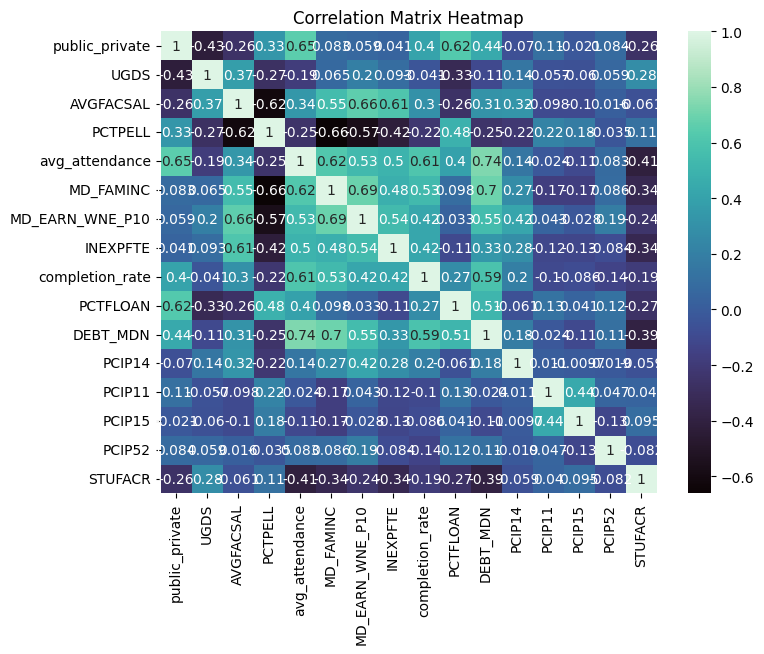

In [10]:
# Correlation matrix
corr_vars = ['public_private', 'UGDS','AVGFACSAL', 'PCTPELL', 'avg_attendance', 'MD_FAMINC',
    'MD_EARN_WNE_P10', 'INEXPFTE', 'completion_rate', 'PCTFLOAN', 'DEBT_MDN', 
    'PCIP14', 'PCIP11', 'PCIP15', 'PCIP52', 'STUFACR']
corr_matrix = df3[corr_vars].corr()

print("Correlation Matrix:")
print(corr_matrix)

# Heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='mako')
plt.title('Correlation Matrix Heatmap')
plt.show()

## Discretization and Transformations

To address skewness and scale differences in the data, we applied several transformations to specific variables. These transformations help ensure that the features align more closely with the assumptions of linear regression, improving model performance and interpretability.

### Log Transformations
Due to right-skewed distributions, we applied a log transformation to certain continuous variables. The log transformation helps reduce skewness, making the data more symmetric and suitable for linear modeling. The following features were log-transformed:
- **UGDS**: Undergraduate enrollment.
- **AVGFACSAL**: Average faculty salary.
- **MD_FAMINC**: Median family income.
- **INEXPFTE**: Instructional expenditure per full-time equivalent student.
- **avg_attendance**: Average cost of attendance.
- **DEBT_MDN**: Median debt of graduates.
- **MD_EARN_WNE_P10**: Median earnings 10 years after enrollment (target variable).

### Data Filtering
After the log transformation, we observed that certain rows in `MD_FAMINC_log` (transformed family income) still exhibited skew. To address this, we filtered out rows where `MD_FAMINC_log` was below 0.6, improving the distribution of the data and reducing the impact of extreme outliers.

### Distribution Visualization
Finally, we plotted histograms for key features to verify the effectiveness of the transformations. The improved distributions confirm that the transformations were successful in reducing skew and preparing the data for modeling.



In [11]:
df3['UGDS_log'] = np.log1p(df3['UGDS'])
df3['AVGFACSAL_log'] = np.log1p(df3['AVGFACSAL'])
df3['MD_FAMINC_log'] = np.log1p(df3['MD_FAMINC'])
df3['INEXPFTE_log'] = np.log1p(df3['INEXPFTE'])
df3['avg_attendance_log'] = np.log1p(df3['avg_attendance'])
df3['DEBT_MDN_log'] = np.log1p(df3['DEBT_MDN'])
df3['MD_EARN_WNE_P10_log'] = np.log1p(df3['MD_EARN_WNE_P10'])

In [12]:
# Remove rows where MD_FAMINC_log is below 0.6
df3 = df3[df3['MD_FAMINC_log'] >= 0.6]

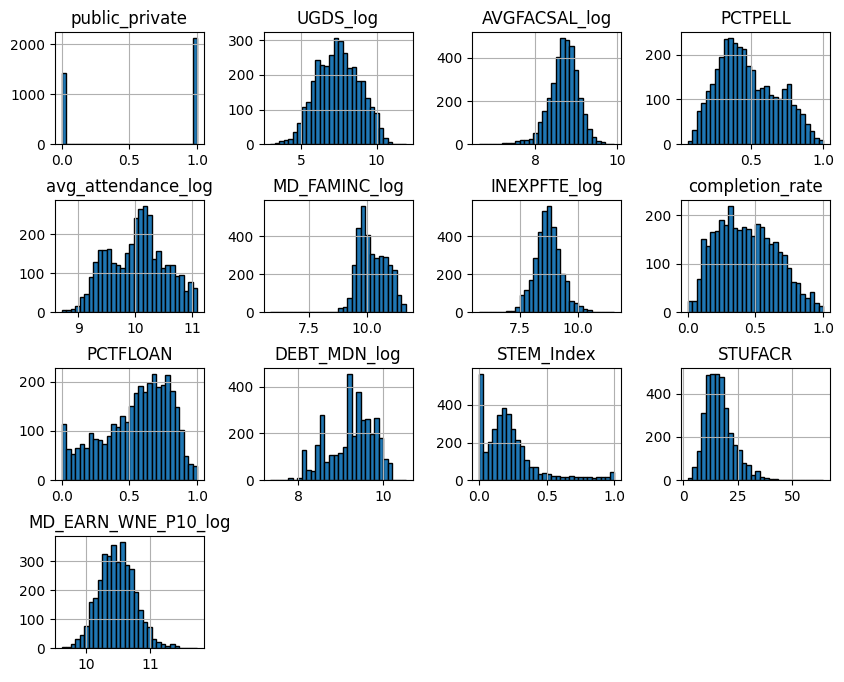

In [13]:
# Sum of proportions of degrees in Engineering, Computer Science, and other STEM fields
df3['STEM_Index'] = df3['PCIP14'] + df3['PCIP11'] + df3['PCIP15'] + df3['PCIP52']

# Plot histograms to check distribution
df3[['public_private', 'UGDS_log','AVGFACSAL_log', 'PCTPELL', 'avg_attendance_log', 'MD_FAMINC_log',
    'INEXPFTE_log', 'completion_rate', 'PCTFLOAN', 'DEBT_MDN_log', 'STEM_Index',
    'STUFACR', 'MD_EARN_WNE_P10_log']].hist(bins=30, figsize=(10, 8),edgecolor='black')
plt.subplots_adjust(hspace=0.5, wspace=0.4)
plt.show()

## Multicollinearity Assessment and Feature Selection/Reduction

To ensure that our model is stable and interpretable, we assessed multicollinearity among the features using the **Variance Inflation Factor (VIF)**. High multicollinearity can inflate the standard errors of coefficients, making it difficult to determine the independent effect of each feature on the target variable.

### Variance Inflation Factor (VIF)

The VIF for each feature was calculated as follows:
- **VIF < 5**: Indicates low multicollinearity, suggesting the feature can be reliably included in the model.
- **VIF >= 5**: Indicates high multicollinearity, suggesting the feature may be redundant and could distort model interpretation.

#### Key Findings:
- Most features have VIF values below 5, indicating acceptable levels of multicollinearity for this analysis.
- The `DEBT_MDN_log` feature shows a slightly higher VIF (around 3.73), but it remains below the commonly used threshold of 5, so it was retained.
- The constant term (added for model stability) has a high VIF, but this is typical and does not affect the interpretation of other features.

This assessment confirms that the features included in the model do not exhibit problematic multicollinearity, allowing us to proceed with a stable and interpretable Multiple Linear Regression model.


In [14]:
# Recalculating VIF
X = df3[['UGDS_log','AVGFACSAL_log', 'PCTPELL', 'avg_attendance_log', 'MD_FAMINC_log',
    'completion_rate','DEBT_MDN_log', 'STEM_Index', 'INEXPFTE_log']]

X = X.assign(const=1)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print("Variance Inflation Factors:")
print(vif_data)

Variance Inflation Factors:
              Feature          VIF
0            UGDS_log     2.061106
1       AVGFACSAL_log     2.447083
2             PCTPELL     2.974976
3  avg_attendance_log     3.116179
4       MD_FAMINC_log     4.026595
5     completion_rate     1.898145
6        DEBT_MDN_log     3.731929
7          STEM_Index     1.121959
8        INEXPFTE_log     2.083704
9               const  1755.083243


## Multiple Linear Regression (MLR) Analysis

To quantify the relationship between institutional characteristics and median earnings 10 years after enrollment, we applied **Ordinary Least Squares (OLS) Regression**. This model provides interpretable coefficients that allow us to understand the impact of each feature on the target variable (`MD_EARN_WNE_P10_log`).

In [15]:
# Define X with only the main effect variables
X = df3[['UGDS_log','AVGFACSAL_log', 'PCTPELL', 'avg_attendance_log', 'MD_FAMINC_log',
    'completion_rate','DEBT_MDN_log', 'STEM_Index', 'INEXPFTE_log']]
X = sm.add_constant(X)  # Adds an intercept to the model

# Define the target variable (log-transformed)
y = df3['MD_EARN_WNE_P10_log']

# Fit the MLR model
mlr_model = sm.OLS(y, X).fit()

# Display the summary of the model results
print(mlr_model.summary())

joblib.dump(mlr_model, 'final_mlr_model.pkl')

                             OLS Regression Results                            
Dep. Variable:     MD_EARN_WNE_P10_log   R-squared:                       0.703
Model:                             OLS   Adj. R-squared:                  0.702
Method:                  Least Squares   F-statistic:                     937.3
Date:                 Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                         13:09:17   Log-Likelihood:                 1599.9
No. Observations:                 3574   AIC:                            -3180.
Df Residuals:                     3564   BIC:                            -3118.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  6.2

['final_mlr_model.pkl']

## Model Summary
- **R-squared**: 0.703  
  This indicates that approximately 70.3% of the variance in median earnings (log-transformed) is explained by the features in the model.
- **Adjusted R-squared**: 0.702  
  Similar to the R-squared, this adjusted measure accounts for the number of predictors in the model and suggests a strong fit.
- **F-statistic**: 937.3 (p < 0.001)  
  A highly significant F-statistic indicates that the model as a whole is statistically significant.

### Coefficients and Interpretation
Below are the key features with their coefficients, t-statistics, and p-values. Significant coefficients (p < 0.05) indicate a statistically meaningful relationship with the target variable.

- **Constant (Intercept)**: 6.218  
  Represents the baseline log-transformed earnings when all predictor variables are zero.

- **UGDS_log** (Undergraduate enrollment): 0.028 (p < 0.001)  
  A positive coefficient suggests that higher undergraduate enrollment is associated with slightly higher median earnings.

- **AVGFACSAL_log** (Average faculty salary): 0.132 (p < 0.001)  
  Higher faculty salaries are positively associated with graduate earnings, likely reflecting institutional quality.

- **PCTPELL** (Percentage of Pell Grant recipients): -0.288 (p < 0.001)  
  This negative coefficient indicates that institutions with higher proportions of Pell Grant recipients tend to have lower median earnings, potentially reflecting socioeconomic disparities.

- **avg_attendance_log** (Average cost of attendance): 0.088 (p < 0.001)  
  Higher attendance costs are associated with higher earnings, possibly indicating that more expensive institutions offer higher returns.

- **MD_FAMINC_log** (Median family income): 0.111 (p < 0.001)  
  Family income is positively correlated with earnings, suggesting that socioeconomic background influences long-term outcomes.

- **completion_rate**: 0.043 (p = 0.009)  
  Higher completion rates are modestly associated with higher earnings, underscoring the value of student success and retention programs.

- **DEBT_MDN_log** (Median debt): 0.077 (p < 0.001)  
  Although debt has a positive association with earnings, it likely represents investment in education that correlates with improved outcomes.

- **INEXPFTE_log** (Instructional expenditure per FTE): 0.024 (p < 0.001)  
  Higher instructional spending per student correlates with improved earnings, potentially reflecting institutional resources and educational quality.

### Model Diagnostics
- **Durbin-Watson Statistic**: 1.682  
  Indicates no serious autocorrelation in residuals, suggesting that the error terms are independent.
- **Omnibus and Jarque-Bera Tests**: Significant values indicate slight skewness and kurtosis in residuals, which may affect normality assumptions but are within tolerable limits.

## Conclusion
This Multiple Linear Regression model highlights key institutional and socioeconomic factors associated with earnings outcomes. The positive relationships with faculty salary, family income, and instructional spending underscore the importance of resources in influencing graduate earnings. Conversely, the negative association with Pell Grant percentages suggests areas where institutions can work to improve outcomes for low-income students.


## Model Testing and Evaluation

In this section, we evaluate the MLR model on a separate test set to assess its performance and generalizability. The metrics calculated here provide an overview of how well the model predicts on unseen data.


In [16]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import numpy as np
import pandas as pd

# Step 1: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train the MLR model on the training set
X_train_const = sm.add_constant(X_train)  # Adds an intercept term to the model

# Fit the MLR model
mlr_model = sm.OLS(y_train, X_train_const).fit()

# Step 3: Make predictions on the test set
X_test_const = sm.add_constant(X_test)

# Generate predictions on the test set
y_pred_mlr = mlr_model.predict(X_test_const)

# Step 4: Evaluate the model's performance on the test set
# Calculate Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R²)
mse_mlr = mean_squared_error(y_test, y_pred_mlr)
rmse_mlr = np.sqrt(mse_mlr)
r2_mlr = r2_score(y_test, y_pred_mlr)

# Print the metrics to summarize model performance on the test set
print("Multiple Linear Regression (MLR) Model Metrics on Test Set:")
print(f"- Mean Squared Error (MSE): {mse_mlr:.2f}")
print(f"- Root Mean Squared Error (RMSE): {rmse_mlr:.2f}")
print(f"- R-squared (R²): {r2_mlr:.4f}")

Multiple Linear Regression (MLR) Model Metrics on Test Set:
- Mean Squared Error (MSE): 0.02
- Root Mean Squared Error (RMSE): 0.16
- R-squared (R²): 0.6862


# Saving Model Metrics and Predictions

This code saves the key evaluation metrics and predictions for this model in the `results` folder. By saving these outputs separately, we can quickly access and compare model performance metrics without needing to re-run the entire analysis.

- **Metrics File**: Saves evaluation metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R²) specific to this model.
- **Predictions File**: Saves the actual vs. predicted values, enabling easy comparison of predicted vs. actual values.

In [17]:
# Save these metrics to a text file in the results folder
with open("../results/mlr_model_metrics.txt", "w") as file:
    file.write("Multiple Linear Regression Model Metrics on Test Set:\n")
    file.write(f"- Mean Squared Error: {mse_mlr:.2f}\n")
    file.write(f"- Root Mean Squared Error: {rmse_mlr:.2f}\n")
    file.write(f"- R-squared: {r2_mlr:.4f}\n")

# Save the actual vs. predicted values for further analysis or visualizations
predictions_df_mlr = pd.DataFrame({
    "Actual": y_test,
    "MLR_Predictions": y_pred_mlr
})

# Save predictions to a CSV file in the results folder
predictions_df_mlr.to_csv("../results/mlr_predictions.csv", index=False)